# Importing libraries

In [11]:
import selenium
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import json 
import gdown
import os
import pytesseract
from PIL import Image
from collections import Counter
import numpy as np
import pickle

In [63]:
driver = webdriver.Chrome()
driver.get("https://www.airbnb.fr/s/paris/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&monthly_start_date=2024-05-01&monthly_length=3&monthly_end_date=2024-08-01&price_filter_input_type=0&channel=EXPLORE&date_picker_type=calendar&source=structured_search_input_header&search_type=filter_change&price_filter_num_nights=6&checkin=2024-05-06&checkout=2024-05-12&adults=2&children=2&query=Paris%2C%20France&place_id=ChIJD7fiBh9u5kcRYJSMaMOCCwQ&federated_search_session_id=62139ace-d3f9-42a5-876f-3a810c907664&pagination_search=true&cursor=eyJzZWN0aW9uX29mZnNldCI6MCwiaXRlbXNfb2Zmc2V0IjowLCJ2ZXJzaW9uIjoxfQ%3D%3D")

# Functions creation

In [13]:
def get_text(xpath):

    """
    This function takes the xpath of an element as an argument
    It returns the text of the specified element
    """
    
    return driver.find_element(By.XPATH, xpath).text

In [14]:
def click(xpath):

    """
    This function takes the xpath of an element
    It clicks on the element with the specified xpath
    It doesn't return anything
    """
    
    driver.find_element(By.XPATH, xpath).click()

In [15]:
def next_page():

    """
    This function doesn't take anything as an argument
    It finds the element to go to the next page, and then clicks on it 
    """
    
    driver.find_element(By.XPATH, "//a[@aria-label='Suivant']").click()

In [16]:
def switch():

    """"
    This function doesn't take anything as an argument
    It retrieves the identifiers of the windows opened by the browser controlled by the driver
    It then switchs to the last window
    The function doesn't return anything
    """

    window_handles = driver.window_handles

    driver.switch_to.window(window_handles[-1])

In [17]:
def close():

    """
    This function doesn't take anything as an argument
    It closes the window the driver is currently on
    It uses the switch function, to go back on the main window
    The function doesn't return anything
    """
    
    driver.close()
    switch()

In [18]:
def get_price():
    try:
        price = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[3]/div/div[2]/div/div/div[1]/div/div/div/div/div/div/div/div[1]/div[1]/div/div/span/div/span[2]").text
        if price.count('€')==1:
            return price
        else: raise Exception
    
    except:return get_text('/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[3]/div/div[2]/div/div/div[1]/div/div/div/div/div/div/div/div[1]/div[1]/div/div/span/div/span[1]')

In [20]:
def get_equipments():

    """
    This function doesn't take anything as an argument
    It returns all equipments that are pre
    It filters out elements containing the text "Indisponible"
    and returns the remaining text content of those elements
    """
    try:
        driver.find_elements(By.XPATH,"//*[contains(text(), 'Afficher les')]")[0].click()
        time.sleep(.3)
        equipments = driver.find_elements(By.XPATH, ("//div[@class='rten07p atm_lo_1tcgj5g atm_le_1tcgj5g atm_5j_t94yts dir dir-ltr']"))
        equipments = [i.text for i in equipments if 'Indisponible' not in i.text]
        classe = "c11vnb9k atm_mk_stnw88 atm_9s_1txwivl atm_tk_exct8b atm_fq_1tcgj5g atm_wq_kb7nvz atm_1wn1q82_xond3e atm_tk_1tcgj5g__oggzyc dir dir-ltr"
        driver.find_element(By.XPATH, (f"//div[@class='{classe}']")).click()
        time.sleep(1)
    except:
        equipments=[]
    return equipments


In [21]:
def get_offers():
    
    """
    This funtions doesn't take anything as an argument
    It returns a list of the offers on the main window as selenium elements
    """

    return driver.find_elements(By.XPATH, "//div[@class='lxq01kf atm_9s_1txwivl atm_am_kyuy1d atm_ar_d67k9l l1tup9az atm_1p4glcj_1bp4okc dir dir-ltr']")

In [22]:
def go_to(element):

    """
    This function takes an element as an argument
    It excutes javascript code scroll the page until the specified element is visible within the browser window
    This function doesn't return anything
    """

    driver.execute_script("arguments[0].scrollIntoView(true);", element)

In [23]:
def get_description():

    """
    This function takes an element as an argument
    It returns the description of the offer written by the offerer
    """

    classe = "d1isfkwk atm_vv_1jtmq4 dir dir-ltr"
    return driver.find_element(By.XPATH, (f"//div[@class='{classe}']")).text

In [24]:
def get_size():

    """
    This function doesn't take anything as an element
    It uses the get_description function and then searches in it the square meters notation and define the index where
    the notation has been found
    It then extracts a string near the index and extracts just the numbers to get the size of the appartment
    """

    description = get_description()
    description += " "+driver.find_element(By.XPATH,"/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[1]/div[1]/div/div/div/div/div/section/div/div[1]/span/h1").text
    size = ""
    string = ""

    if description.__contains__('m²') or description.__contains__('m2') or description.__contains__('m 2'):
        if description.__contains__('m²'):
            index = description.index("m²")
        elif description.__contains__('m 2'):
            index = description.index('m 2')
        else:
            index = description.index("m2")
        
        for i in range(6):
            try:
                string += description[index-3 + i]
            except:
                pass

        

        for i in string:
            if i.isdigit():
                size+=i
        size = int(size[:-1])
        
    else:
        size = 0
   
    
    return size

In [25]:
def get_info():

    """
    This function doesn't take anything as an element
    It returns the information about the offer such as the capacity of the appartment, the number of bedrooms,
    the number of beds and the number of bathrooms
    This function isn't used for the moment because it needs to corrected
    """
    
    tag = "o1kjrihn atm_c8_km0zk7 atm_g3_18khvle atm_fr_1m9t47k atm_h3_1y44olf atm_c8_2x1prs__oggzyc atm_g3_1jbyh58__oggzyc atm_fr_11a07z3__oggzyc dir dir-ltr"
    info = driver.find_element(By.XPATH, f"//div[@class='{tag}']").text.split("·")
    info

    nb_of_travellers, nb_of_bedrooms, nb_of_beds, nb_of_bathrooms = 0,0,0,0

    for i in info:
        if i.__contains__('voyageur'):
            try:
                nb_of_travellers = int(i.split()[0])
            except:pass
        if i.__contains__('chambre'):
            try:
                nb_of_bedrooms = int(i.split()[0])
            except:pass
        if i.__contains__('lit'):
            try:    
                nb_of_beds = int(i.split()[0]) 
            except:pass 
        if i.__contains__('de bain'):
            try:
                nb_of_bathrooms = int(i.split()[0])
            except:pass


    return nb_of_travellers, nb_of_bedrooms, nb_of_beds, nb_of_bathrooms
    

In [26]:
def to_df(liste) :

    """
    This function takes a list as an argument
    The list given in argument should have the same format than the one from the scraping
    It returns a pandas dataframe from the list
    """

    dico = {}
    dico['prix'] = []
    dico['size'] = []
    dico['nb_of_travellers'] = []
    dico['nb_of_bedrooms'] = []
    dico['nb_of_beds'] = []
    dico['nb_of_bathrooms'] = []
    dico['arrondissement'] = []
    for i in liste:
        for j in i[7]:
            dico[j] = []

    for i in liste:
        prix = int(i[0].split()[0])
        size = i[1]
        nb_of_travellers = i[2]
        nb_of_bedrooms = i[3]
        nb_of_beds = i[4]
        nb_of_bathrooms = i[5]
        arrondissement = i[6]

        equipements = i[7]
        dico['prix'].append(prix)
        dico['size'].append(size)
        dico['nb_of_travellers'].append(nb_of_travellers)
        dico['nb_of_bedrooms'].append(nb_of_bedrooms)
        dico['nb_of_beds'].append(nb_of_beds)
        dico['nb_of_bathrooms'].append(nb_of_bathrooms)
        dico['arrondissement'].append(arrondissement)
        for j in dico:
            if j not in ["prix", "size", "nb_of_travellers", "nb_of_bedrooms", "nb_of_beds", "nb_of_bathrooms", "arrondissement"]:
                if j in equipements:
                    dico[j].append(1)
                else:
                    dico[j].append(0)

    df = pd.DataFrame(dico)

    return df

In [223]:
def get_data():
    file_id = '1gCYzEUEn1O9LQlax8BD0u52dfiKtgUPD'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'data.csv', quiet=False)
    df = pd.read_csv('data.csv')
    return df



In [28]:
def go_to_map():
    go_to(driver.find_element(By.XPATH, "//*[contains(text(), 'Où se situe le logement')]"))

In [29]:
def get_arrondissement(arrondissement):
    go_to_map()
    time.sleep(.5)
    bouton = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[5]/div/div/div/div[2]/section/div[3]/div[3]/button[1]")
    for i in range(3):
        bouton.click()
        driver.save_screenshot(f"test{i}.png")
        time.sleep(.1)
    #time.sleep(1)
    text =""
    driver.save_screenshot("test3.png")
    for i in range(4):
        image = Image.open(f'test{i}.png')

        text += pytesseract.image_to_string(image).replace('est',"")


    test = []

    for i in text.rsplit():
        if i.lower() in list(arrondissement['voie']):

            test.append(arrondissement[arrondissement['voie'] == i.lower()]['Arrondissement'].value_counts().idxmax())

    try:    
        return Counter(test).most_common(1)[0][0]
    except:
        return 0
    #return test

In [30]:
def get_loc():
    
    r = []
    for j in get_description().split():
        i = j.replace(',',"").replace('.','')
        if i in station:
            #print(i)
            r.append(metro[metro['Libelle station'] == i]['arrondissement'].value_counts().idxmax())

    time.sleep(1)
    try:
        more = driver.find_element(By.XPATH, "//*[contains(text(), 'Points forts du quartier')]")
        go_to(more)
        time.sleep(.5)
        try:
            driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[5]/div/div/div/div[2]/section/div[6]/button/span/span[1]").click()
        except:
            driver.find_element(By.XPATH,"/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[5]/div/div/div/div[2]/section/div[5]/button/span/span[1]").click()
        time.sleep(2)
        driver.find_element(By.XPATH, "/html/body/div[9]/div/div/section/div/div/div[2]/div/div[3]/div/div[1]/section/div[2]/div/button/span/span[1]").click()

        nice = driver.find_element(By.XPATH,"/html/body/div[9]/div/div/section/div/div/div[2]/div/div[3]/div/div[1]/section/div[2]/div/div[2]").text

        for j in nice.split():
            i = j.replace(',',"").replace('.','')
            if i in station:
                #print(i)
                r.append(metro[metro['Libelle station'] == i]['arrondissement'].value_counts().idxmax())
    except:
        if r==[]:
            try:
                arr = (get_arrondissement(arrondissement))
                return arr
            except:
                pass

    try:    
        return Counter(r).most_common(1)[0][0]
    except:
        return 0
    

In [31]:
def scraping(arrondissement):
    time.sleep(2)

    liste = []
    for j in range(15):
        
        
        offers = get_offers()
        for i in range(len(offers)):

            time.sleep(.5)
            go_to(offers[i])
            offers[i].click()
            time.sleep(.1)
            switch()
            try:
                WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, '/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[3]/div/div[2]/div/div/div[1]/div/div/div/div/div/div/div/div[1]/div[1]/div/div/span/div/span[1]'))).click()
            except : 
                close()
                continue

            liste.append([])

            liste[-1].append(get_price())
            liste[-1].append(get_size())
            
            for i in get_info():
                liste[-1].append(i)
            equipments = get_equipments()
            
            liste[-1].append(get_loc())
            try:
                liste[-1].append(equipments)
            except:
                liste[-1].append([])

            
            close()
        
        if j!=14:
            next_page()
        time.sleep(2)

    return liste

# SCRAPING


In [69]:
liste = []

In [125]:
switch()

In [124]:
len(liste)

962

In [126]:

for j in range(15):

    offers = get_offers()
    for i in range(len(offers)):


            time.sleep(.5)
            go_to(offers[i])
            offers[i].click()
            time.sleep(.1)
            switch()
            try:
                WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, '/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[3]/div/div[2]/div/div/div[1]/div/div/div/div/div/div/div/div[1]/div[1]/div/div/span/div/span[1]'))).click()
            except : 
                close()
                continue

            liste.append([])

            liste[-1].append(get_price())
            size = get_size()
            print(size)
            liste[-1].append(size)
            
            for i in get_info():
                liste[-1].append(i)
            equipments = get_equipments()
            r = []
            description = get_description()
            try:description += " " + driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[1]/div[1]/div/div/div/div/div/section/div/div[1]/span/h1").text
            except:pass
            for j in description.split():
                i = j.replace(',',"").replace('.','')
                if i in station:
                    #print(i)
                    r.append(metro[metro['Libelle station'] == i]['arrondissement'].value_counts().idxmax())


            try:
                more = driver.find_element(By.XPATH, "//*[contains(text(), 'Points forts du quartier')]")
                go_to(more)
                time.sleep(.5)
                try:
                    driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[5]/div/div/div/div[2]/section/div[6]/button/span/span[1]").click()
                except:
                    driver.find_element(By.XPATH,"/html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main/div/div[1]/div[5]/div/div/div/div[2]/section/div[5]/button/span/span[1]").click()
                time.sleep(.2)
                driver.find_element(By.XPATH, "/html/body/div[9]/div/div/section/div/div/div[2]/div/div[3]/div/div[1]/section/div[2]/div/button/span/span[1]").click()

                nice = driver.find_element(By.XPATH,"/html/body/div[9]/div/div/section/div/div/div[2]/div/div[3]/div/div[1]/section/div[2]/div/div[2]").text

                for j in nice.split():
                    i = j.replace(',',"").replace('.','')
                    if i in station:
                        #print(i)
                        r.append(metro[metro['Libelle station'] == i]['arrondissement'].value_counts().idxmax())
            except:pass
            if r!=[]:liste[-1].append(Counter(r).most_common(1)[0][0])
            
            else:liste[-1].append(0)
            try:
                liste[-1].append(equipments)
            except:
                liste[-1].append([])

            close()
    if j!=14:
        next_page()
    time.sleep(2)

60
80
60
0
0
30
60
0
89
0
0
0
0
39
0
71
0
75
90
65
0
0
42
12
0
0
55
0
0
0
0
32
72
90
90
0
42
0
73
0
0
65
0
75
0
40
52
0
0
0
44
20
0
0
20
75
0
0
52
0
55
75
0
0
0
125
0
0
0
140
75
0
0
82
0
0
0
0
0
0
57
0
90
50
90
0
0
140
24
0
45
90
0
35
0
72
0
75
0
0
0
30
80
0
0
0


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//a[@aria-label='Suivant']"}
  (Session info: chrome=124.0.6367.93); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x00000001027928cc chromedriver + 4368588
1   chromedriver                        0x000000010278ad60 chromedriver + 4336992
2   chromedriver                        0x00000001023aec04 chromedriver + 289796
3   chromedriver                        0x00000001023f0e00 chromedriver + 560640
4   chromedriver                        0x00000001024295ec chromedriver + 792044
5   chromedriver                        0x00000001023e5ab4 chromedriver + 514740
6   chromedriver                        0x00000001023e650c chromedriver + 517388
7   chromedriver                        0x0000000102756de8 chromedriver + 4124136
8   chromedriver                        0x000000010275bbd8 chromedriver + 4144088
9   chromedriver                        0x000000010273c7b0 chromedriver + 4016048
10  chromedriver                        0x000000010275c508 chromedriver + 4146440
11  chromedriver                        0x000000010272e264 chromedriver + 3957348
12  chromedriver                        0x000000010277be50 chromedriver + 4275792
13  chromedriver                        0x000000010277bfcc chromedriver + 4276172
14  chromedriver                        0x000000010278a9c0 chromedriver + 4336064
15  libsystem_pthread.dylib             0x000000018d3c426c _pthread_start + 148
16  libsystem_pthread.dylib             0x000000018d3bf08c thread_start + 8


In [21]:
df = pd.read_csv('scott2.csv')

In [127]:
len(liste)

1068

In [129]:
for i in range(len(liste)):
    if len(liste[i]) != 8:
        print(i)

961


In [176]:
df = pd.read_csv('scott2.csv').drop_duplicates()

In [218]:
df =  get_data().drop('Unnamed: 0', axis=1)

Downloading...
From: https://drive.google.com/uc?id=1gCYzEUEn1O9LQlax8BD0u52dfiKtgUPD
To: /Users/julius/Desktop/école/python/ML/ML_POC/albert_project/notebooks/data.csv
100%|██████████| 938k/938k [00:01<00:00, 917kB/s]


In [219]:
df

,prix,size,nb_of_travellers,nb_of_bedrooms,nb_of_beds,nb_of_bathrooms,arrondissement,Lave-linge,Télévision,Piano,...,Wifi rapide (483 Mbit/s)\nVérifié par un test de débit. Il est possible de regarder des vidéos 4K en streaming et de participer à des appels vidéo sur plusieurs appareils.,Four samsung,Cuisinière à induction Electrolux en acier inoxydable,Wifi rapide (347 Mbit/s)\nVérifié par un test de débit. Il est possible de regarder des vidéos 4K en streaming et de participer à des appels vidéo sur plusieurs appareils.,Cuisinière à induction Siemens,Réfrigérateur ikea,Shampoing Monoprix,Savon pour le corps Monoprix,"TV HD avec Netflix, abonnement standard au câble, Amazon Prime Video",Réfrigérateur Darty
0,90,0,4,1,2,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,144,0,4,2,3,1,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,124,0,4,1,0,1,19,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,258,35,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,140,0,4,1,1,1,20,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,120,0,2,1,0,1,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
898,150,0,2,1,1,1,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
899,60,0,1,0,1,1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
900,133,50,2,1,0,1,11,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse, accuracy_score


y = df['prix']
#X = df[["size","nb_of_travellers", "nb_of_bedrooms", "nb_of_beds", 'nb_of_bathrooms', 'arrondissement']]

X = df.drop(["prix" ], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse(y_test, y_pred)**.5



31.26451044330726

In [194]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()
mean_mse**.5

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


50.749565675050476

In [172]:
y_test.mean()

160.22099447513813

In [222]:
mse(y_test, y_pred)**.5/np.mean(y_test)


0.1951336686289177

In [196]:
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [11]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [59]:
csv = pd.read_csv('/Users/julius/Downloads/stationnement-voie-publique-emplacements (1).csv', sep=";")
arrondissement = csv[['Arrondissement',"Type voie", "Nom voie"]]
arrondissement['voie'] = arrondissement['Nom voie'].apply(lambda x: x.lower())
arrondissement = arrondissement.drop_duplicates()

/var/folders/s0/8hy_l2q51bl1z2t841qjj8d00000gn/T/ipykernel_40703/893680652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrondissement['voie'] = arrondissement['Nom voie'].apply(lambda x: x.lower())


In [33]:
metro = pd.read_csv('/Users/julius/Downloads/metro-france.csv', sep=";")
metro = metro[metro['Commune nom'].str.contains("Paris")]

def nums(text):
    q=""
    for i in text:
        if i.isdigit():q+=i 
    return int(q)

metro['arrondissement'] = metro['Commune nom'].apply(lambda x:nums(x))
station  = list(metro[metro['Commune nom'].str.contains("Paris")]['Libelle station'])

In [202]:
df

,prix,size,nb_of_travellers,nb_of_bedrooms,nb_of_beds,nb_of_bathrooms,arrondissement,Lave-linge,Télévision,Piano,...,Wifi rapide (483 Mbit/s)\nVérifié par un test de débit. Il est possible de regarder des vidéos 4K en streaming et de participer à des appels vidéo sur plusieurs appareils.,Four samsung,Cuisinière à induction Electrolux en acier inoxydable,Wifi rapide (347 Mbit/s)\nVérifié par un test de débit. Il est possible de regarder des vidéos 4K en streaming et de participer à des appels vidéo sur plusieurs appareils.,Cuisinière à induction Siemens,Réfrigérateur ikea,Shampoing Monoprix,Savon pour le corps Monoprix,"TV HD avec Netflix, abonnement standard au câble, Amazon Prime Video",Réfrigérateur Darty
0,90,0,4,1,2,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,144,0,4,2,3,1,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,124,0,4,1,0,1,19,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,258,35,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,140,0,4,1,1,1,20,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,120,0,2,1,0,1,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
898,150,0,2,1,1,1,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
899,60,0,1,0,1,1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
900,133,50,2,1,0,1,11,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='arrondissement'>

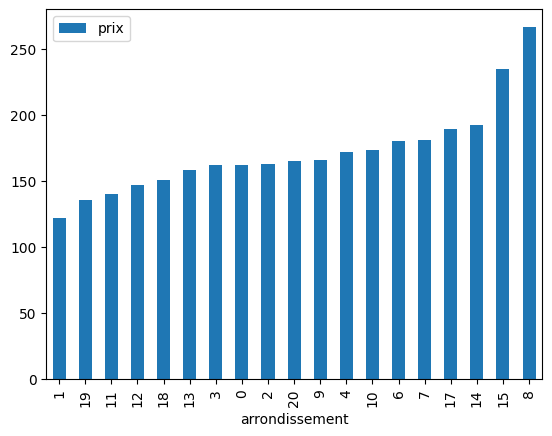

In [206]:
df[['prix','arrondissement']].groupby('arrondissement').mean().sort_values('prix').plot(kind='bar')

In [207]:
df

,prix,size,nb_of_travellers,nb_of_bedrooms,nb_of_beds,nb_of_bathrooms,arrondissement,Lave-linge,Télévision,Piano,...,Wifi rapide (483 Mbit/s)\nVérifié par un test de débit. Il est possible de regarder des vidéos 4K en streaming et de participer à des appels vidéo sur plusieurs appareils.,Four samsung,Cuisinière à induction Electrolux en acier inoxydable,Wifi rapide (347 Mbit/s)\nVérifié par un test de débit. Il est possible de regarder des vidéos 4K en streaming et de participer à des appels vidéo sur plusieurs appareils.,Cuisinière à induction Siemens,Réfrigérateur ikea,Shampoing Monoprix,Savon pour le corps Monoprix,"TV HD avec Netflix, abonnement standard au câble, Amazon Prime Video",Réfrigérateur Darty
0,90,0,4,1,2,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,144,0,4,2,3,1,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,124,0,4,1,0,1,19,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,258,35,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,140,0,4,1,1,1,20,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,120,0,2,1,0,1,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
898,150,0,2,1,1,1,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
899,60,0,1,0,1,1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
900,133,50,2,1,0,1,11,0,1,0,...,0,0,0,0,0,0,0,0,0,0
